# A Resnet Variant for Gomoku

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime as dt
import random

import numpy as np
import tensorflow as tf
import keras
from keras import layers

from aegomoku.game_data import read_training_data, create_dataset
import keras.initializers.initializers_v2 as initializers
from aegomoku.policies.primary_detector import PrimaryDetector

# Training on Terminal Threats
Let's start easy. terminal threats are lines of 4 with at least one open end. These positions MUST be taken or the opponents next move terminates the game in her favor.

In [3]:
BOARD_SIZE=15
filename = "rawdata.pickle"
examples = read_training_data(filename, BOARD_SIZE)
len(examples), len(examples[0]), examples[0][0].shape, np.array(examples[0][1]).shape

(20320, 3, (17, 17, 3), (225,))

# Trainable components combined with a heuristic *advisor*
Actually, it's boring feature engineering, what we're doing here. And yes that's exactly why this is **Alpha Epsilon** - not quite **Alpha Zero**: We induce a little *bias* by providing knowledge about the most critical positions

In [4]:
inputs = keras.Input(shape=(17, 17, 3), name="inputs")

In [5]:
def xp(n, filters, kernel):
    return layers.Conv2D(
        name=f"expand_{n}_{kernel}x{kernel}",
        filters=filters, kernel_size=kernel,
        kernel_initializer=initializers.TruncatedNormal(seed=1, stddev=0.08),
        bias_initializer=tf.constant_initializer(0.),
        activation=tf.nn.softplus,
        padding='same')

In [6]:
def ct(n, filters, kernel):
    return layers.Conv2D(
        name=f"contract_{n}_{kernel}x{kernel}",
        filters=filters, kernel_size=kernel,
        kernel_initializer=initializers.TruncatedNormal(seed=1, stddev=0.08),
        bias_initializer=tf.constant_initializer(0.),
        activation=tf.nn.softplus,
        padding='same')

In [7]:
policy_aggregate = layers.Conv2D(
    name="policy_aggregator",
    filters=1, kernel_size=1,
    kernel_initializer=initializers.TruncatedNormal(seed=1, stddev=0.08),
    bias_initializer=tf.constant_initializer(0.),
    activation=tf.nn.relu,
    padding='same')

In [8]:
peel = layers.Conv2D(
    name="border_off",
    filters=1, kernel_size=(3, 3),
    kernel_initializer=tf.constant_initializer([[0., 0., 0.], [0., 1., 0.], [0., 0., 0.]]),
    bias_initializer=tf.constant_initializer(0.),
    padding='valid',
    trainable=False)

In [9]:
advisor = PrimaryDetector(BOARD_SIZE, activation=tf.keras.activations.tanh, name='heuristics')

/home/wgiersche/.local/share/virtualenvs/DeepGomoku-yQC4gx5q/lib/python3.8/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [10]:
features = advisor(inputs)
features=tf.keras.activations.tanh(features)
x = xp(1, 1024, 11)(inputs)
c = ct(1, 4, 5)(x)

for i in range(2, 21):
    i1 = layers.concatenate([features, c], axis=-1)
    x1 = xp(i, 32, 5)(i1)
    c1 = ct(i, 4, 3)(x1)
    c = layers.Add(name=f"skip_{i}")([c1, c])

x = policy_aggregate(c)
y = peel(x)
flatten = layers.Flatten()(y)
softmax = layers.Softmax()(flatten)
model = keras.Model(inputs=inputs, outputs=softmax)
model.compile()
model.summary()

2022-08-20 16:11:10.431399: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-20 16:11:10.432862: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-20 16:11:10.440894: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-20 16:11:10.441969: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-20 16:11:10.443230: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 17, 17, 3)]  0           []                               
                                                                                                  
 heuristics (PrimaryDetector)   (None, 17, 17, 5)    113288      ['inputs[0][0]']                 
                                                                                                  
 expand_1_11x11 (Conv2D)        (None, 17, 17, 1024  372736      ['inputs[0][0]']                 
                                )                                                                 
                                                                                                  
 tf.math.tanh (TFOpLambda)      (None, 17, 17, 5)    0           ['heuristics[0][0]']         

---



# Policy Output of the Untrained Model
From experience we can tell that the training will most likely succeed when we see some structured output here. For unknown reasons, some architectures initialize such that the untrained network produces a flat policy output.

In [11]:
n = random.randint(0, 100)
sample = np.expand_dims(examples[n][0], axis=0).astype(float)
p = model(sample)
print((np.squeeze(p)*999).astype(np.uint8))

2022-08-20 16:11:15.386916: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-08-20 16:11:15.572853: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  1  4  3  3  2  3  3  3  2  3  3  2  3  3  2  3  5  3  3
  3  3  3  3  3  4  4  3  4  4  4  6  5  4  3  3  3  3  3  2  3  3  3  3
  3  6  7  5  4  3  3  3  3  3  2  3  2  2  3  3  5  5  5  5  3  3  3  4
  3  4  3  4  3  4  3  5  5  5  4  3  3  3  3  3  3  3  3  3  3  3  6  5
  5  4  3  3  3  3  3  3  3  3  2  3  2  4  4  6  5  3  3  4  3  4  3  3
  4  3  4  3  5  5  6  5  4  3  4  4  3  3  3  4  3  4  3  6  5  6  5  3
  3  3  4  4  4  4  4  3  3  2  4  3  9  4  4  4  4  5  4  4  4  4  4  3
  2  3  4 14 10 12 13 15 13 13 13 13 13 11 11  8  7  4  7 10  9  9 10 11
 10 11 11 10  8  6  3  1  0]


---

# Training

In [12]:
policy_loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [13]:
metric = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)

def train(train_examples, epochs_per_train=100, report_every=100):
    current_time = dt.datetime.now().strftime("%Y%m%d-%H%M%S")
    train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)

    all_train_ds = create_dataset(train_examples)

    for epoch in range(epochs_per_train):
        for x_train, pi_train, _ in all_train_ds:
            train_step(x_train, pi_train)
        with train_summary_writer.as_default():
            tf.summary.scalar('loss', metric.result(), step=epoch)

        if epoch % report_every == 1:
            print(f'Epoch: {epoch}, Training: {metric.result()}')

    print(f'Epochs: {epochs_per_train}, Loss: {metric.result()}')

    metric.reset_states()

@tf.function
def train_step(x, pi_y):
    with tf.GradientTape() as tape:
        probs = model(x, training=True)
        total_loss = policy_loss(pi_y, probs)

    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    metric(total_loss)

In [14]:
N = 2000
train(examples[:N], epochs_per_train=20, report_every=5)

Epoch: 1, Training: 5.0291290283203125
Epoch: 6, Training: 4.844454288482666
Epoch: 11, Training: 4.732596397399902
Epoch: 16, Training: 4.3285393714904785
Epochs: 20, Loss: 4.015460014343262


In [10]:
N = 5000
train(examples[:N], epochs_per_train=200, report_every=20)

Epoch: 1, Training: 1.4426692724227905
Epoch: 21, Training: 1.0760084390640259
Epoch: 41, Training: 0.9827200174331665
Epoch: 61, Training: 0.9259703755378723
Epoch: 81, Training: 0.8906920552253723
Epoch: 101, Training: 0.8650811314582825
Epoch: 121, Training: 0.8462158441543579
Epoch: 141, Training: 0.8315414190292358
Epoch: 161, Training: 0.8197803497314453
Epoch: 181, Training: 0.8102224469184875
Epochs: 200, Loss: 0.8028954267501831


---
# Convincing Performance on Unseen Examples
With loss values below 1.2 we already have sufficient performance on the terminal threat dataset. Sufficient means that if there's only one terminal threat on the board, the policy will include it, at least among other moves that the tree search can then easily rule out.

n=11727
Next to play: WHITE
Value from WHITE's point of view: -0.4885607496682389
Next to play: WHITE
Value from WHITE's point of view: 0.0


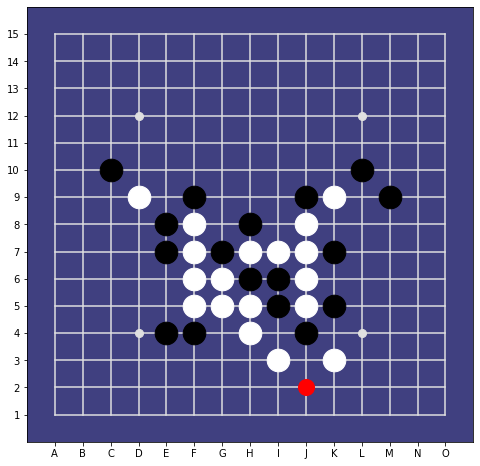

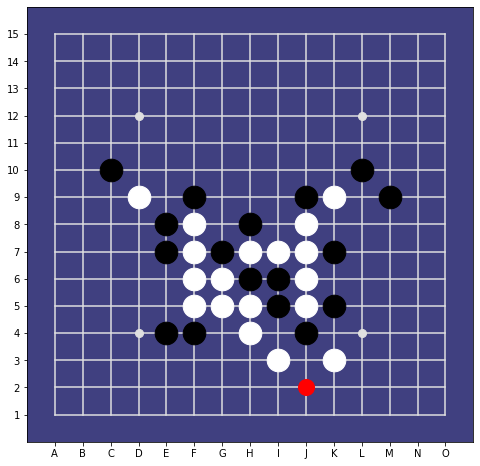

In [19]:
from aegomoku.utils import analyse_example

n = random.randint(N, len(examples))
sample = np.expand_dims(examples[n][0], axis=0).astype(float)
p_ = model(sample)
s, p, _ = examples[n]
example = (s, list(p_.numpy()), 0.0)
print(f"n={n}")
analyse_example(BOARD_SIZE, examples[n])
analyse_example(BOARD_SIZE, example)

---

# All of that is now in GomokuResnet

In [4]:
from aegomoku.gomoku_resnet import GomokuResnet

model = GomokuResnet(board_size=15, num_blocks=20, num_sensor_filters=1024)
model.summary()

/home/wgiersche/.local/share/virtualenvs/DeepGomoku-yQC4gx5q/lib/python3.8/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape
2022-08-20 16:12:49.343046: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-20 16:12:49.343754: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-20 16:12:49.348919: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (

Model: "gomoku_resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 17, 17, 3)]  0           []                               
                                                                                                  
 heuristic_detector (Conv2D)    (None, 17, 17, 307)  111748      ['inputs[0][0]']                 
                                                                                                  
 expand_1_11x11 (Conv2D)        (None, 17, 17, 1024  372736      ['inputs[0][0]']                 
                                )                                                                 
                                                                                                  
 heuristic_priority (Conv2D)    (None, 17, 17, 5)    1540        ['heuristic_detector[

In [5]:
N=2000
from aegomoku.trainer import Trainer
trainer = Trainer()
ds = create_dataset(examples[:N], batch_size=1024)
trainer.train(model, ds, epochs_per_train=400, report_every=20)

2022-08-20 16:13:08.343141: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-08-20 16:13:08.576111: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


Epoch: 1, Training: 5.020991325378418
Epoch: 11, Training: 4.272425174713135
Epoch: 21, Training: 3.1943483352661133
Epoch: 31, Training: 2.5848121643066406
Epoch: 41, Training: 2.2112584114074707
Epoch: 51, Training: 1.9845856428146362
Epoch: 61, Training: 1.8244866132736206
Epoch: 71, Training: 1.695709228515625
Epoch: 81, Training: 1.599747657775879
Epoch: 91, Training: 1.5170432329177856
Epoch: 101, Training: 1.4490302801132202
Epoch: 111, Training: 1.3919507265090942
Epoch: 121, Training: 1.3434531688690186
Epoch: 131, Training: 1.301072597503662
Epoch: 141, Training: 1.270941972732544
Epoch: 151, Training: 1.240850806236267
Epoch: 161, Training: 1.2127110958099365
Epoch: 171, Training: 1.1869605779647827
Epoch: 181, Training: 1.1647253036499023
Epoch: 191, Training: 1.1449040174484253
Epoch: 201, Training: 1.1265660524368286
Epoch: 211, Training: 1.1093438863754272
Epoch: 221, Training: 1.0933339595794678
Epoch: 231, Training: 1.0784509181976318
Epoch: 241, Training: 1.0664919614

n=8056
Next to play: WHITE
Value from WHITE's point of view: -0.5090889503371377
Next to play: WHITE
Value from WHITE's point of view: 0.0


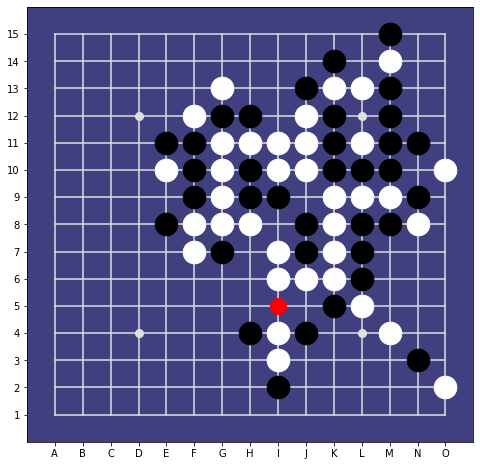

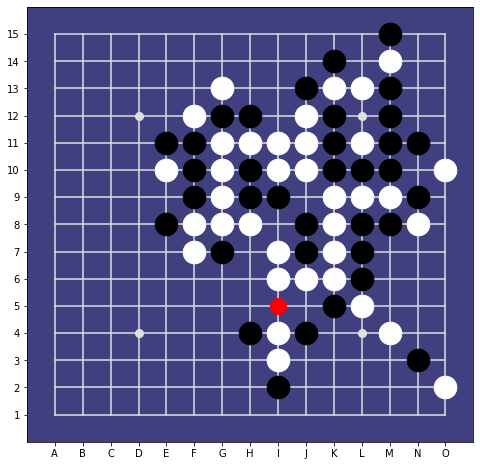

In [18]:
from aegomoku.utils import analyse_example

n = random.randint(N, len(examples))
sample = np.expand_dims(examples[n][0], axis=0).astype(float)
p_ = model(sample)
s, p, _ = examples[n]
example = (s, list(p_.numpy()), 0.0)
print(f"n={n}")
analyse_example(BOARD_SIZE, examples[n])
analyse_example(BOARD_SIZE, example)